In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import csv
import numpy as np
from datetime import datetime, timedelta
from collections import Counter

plt.rcParams['font.family'] = 'Helvetica'

dformat = '%YYYY-%MM-%DD %H:%M:%S.%f'

In [2]:
obs_file = '../db-processing/observation_timestamps.txt'
user_observations = {}
with open(obs_file, 'r') as fh:
    reader = csv.reader(fh, delimiter='\t')
    for line in reader:   
        uid, obs = line[0], line[1]
        obs = obs.split(',')
        if len(obs) and len(obs[0]):
            # don't add empty strings
            user_observations[uid] = obs

In [3]:
# read user_ads_timestamps file
user_ads_file = '../db-processing/user_ads_timestamps.tsv'
user_ads = {}
with open(user_ads_file, 'r') as fh:
    reader = csv.reader(fh, delimiter='\t')
    for line in reader:
        uid = line[0]
        # ignore the ad IDs for now
        timestamps = [x.split(',')[1] for x in line[1:]]
        if len(timestamps) and len(timestamps[0]):
            user_ads[uid] = timestamps

In [4]:
def aggregate_observations(timestamps):
    # group finegrained timestamps into (day, freq) pairs
    dates = [datetime.fromisoformat(ts).date() for ts in timestamps]
    counter = Counter(dates)
    
    # output: list of (date, freq) tuples
    return sorted(counter.items(), key=lambda tup: tup[0])


# not everyone has contributed on every day, map all to fixed timeline
def build_timeline(user_day_contribs, start_date=None, end_date=None):    
    # if start and end date is passed, don't recompute
    if not start_date and not end_date:
        alldays = [x[0] for uid in user_day_contribs for x in user_day_contribs[uid]]
        start_date, end_date = min(alldays), max(alldays)        
    
    start_date = start_date - timedelta(days=1)  # to add zero for when the plugin wasn't installed
    days = (end_date - start_date).days + 1  # +1 = last day included
    date_range = [start_date + timedelta(days=x) for x in range(days)]
    
    user_timelines = {uid: [] for uid in user_day_contribs}
    for uid in user_day_contribs:
        i = 0
        for day in date_range:
            if i < len(user_day_contribs[uid]) and user_day_contribs[uid][i][0] == day:
                # if user made any contributions on this day, manually add cumulative sum in the timeline
                if len(user_timelines[uid]):
                    user_timelines[uid].append(user_timelines[uid][-1] + user_day_contribs[uid][i][1])
                else:
                    user_timelines[uid].append(user_day_contribs[uid][i][1])
                i += 1  # move pointer
            else:
                # no contribs, repeat old number
                if len(user_timelines[uid]):
                    user_timelines[uid].append(user_timelines[uid][-1])                    
                else:
                    user_timelines[uid].append(0)            
    
    return user_timelines, date_range

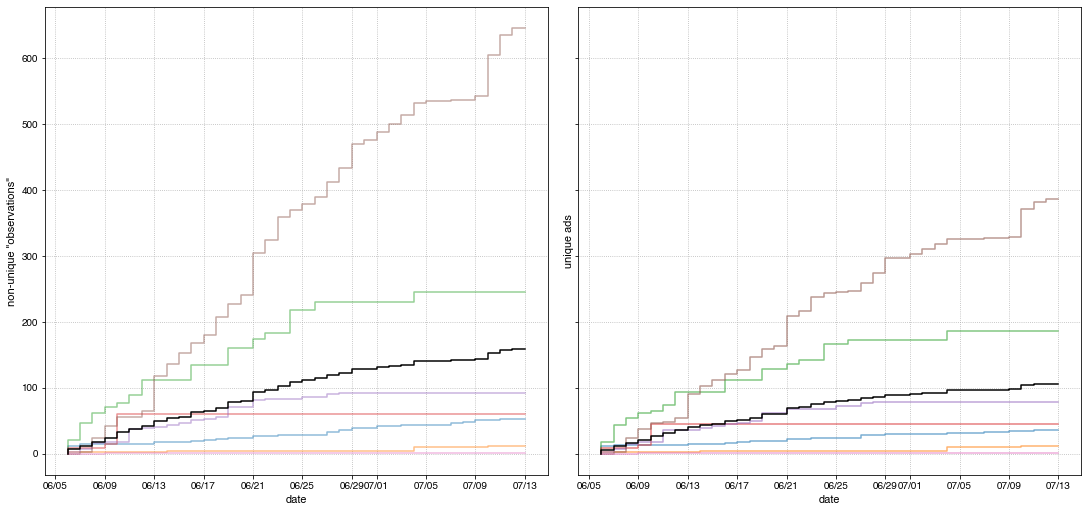

In [12]:
f, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, constrained_layout=True)
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

# NON UNIQUE ADS
user_day_contribs = {}
study_start, study_end = None, None

for uid in user_observations:
    contribs = aggregate_observations(user_observations[uid])
    user_day_contribs[uid] = contribs    
    
timelines, date_range = build_timeline(user_day_contribs)
aggregate = []
for uid in timelines:        
    axs[0].step(date_range, timelines[uid], alpha=.5)
    aggregate.append(timelines[uid])
    
# TODO: plot average    
axs[0].step(date_range, np.mean(np.array(aggregate), axis=0), color='k', label='average')
    
axs[0].grid(ls=':')
axs[0].set_ylabel('non-unique "observations"', fontsize=11)
axs[0].set_xlabel('date', fontsize=11)
# axs[0].set_title('Non-unique ads ("observations") over time')

# === UNIQUE ADS ===

user_day_ads = {}

for uid in user_ads:
    contribs = aggregate_observations(user_ads[uid])
    user_day_ads[uid] = contribs
    
timelines, date_range = build_timeline(user_day_ads)
aggregate = []
for uid in timelines:        
    axs[1].step(date_range, timelines[uid], alpha=.6)
    aggregate.append(timelines[uid])
    
# plot average
axs[1].step(date_range, np.mean(np.array(aggregate), axis=0), color='k', label='average')
    
axs[1].grid(ls=':')
# axs[1].legend()
axs[1].set_ylabel('unique ads', fontsize=11)
axs[1].set_xlabel('date', fontsize=11)
# axs[1].set_title('Unique ads observed over time')

plt.savefig('ads_data_rate.jpg', dpi=200, bbox_inches='tight')

In [5]:
user_ids = list(user_observations.keys())
print('ads:', [len(user_ads[u]) for u in user_ids])
print('obs:', [len(user_observations[u]) for u in user_ids])

print('\ntotal ads:', sum([len(user_ads[u]) for u in user_ids]))
print('total obs:', sum([len(user_observations[u]) for u in user_ids]))

ads: [39, 11, 186, 45, 78, 393, 1]
obs: [56, 11, 245, 60, 92, 663, 1]

total ads: 753
total obs: 1128


In [6]:
# taken from prolific
# (how often you think about debt)_(how much are you saving)
ses_map = {
    '5c6ac9e5d9c5be000174497f': 'sometimes_making-ends-meet',
    '5e3cc28a194a520c0c128f13': 'sometimes_saving-a-little1',
    '609471590c51b81087087049': 'rarely_saving-a-little1',
    '5bba226d70f8df0001c065f3': 'everyday_making-ends-meet',
    '5d1ea7e579b687001af802c6': 'sometimes_saving-a-little2',
    '5df3ab425777b528cb364cde': 'rarely_saving-a-little2',
    '5e1b299528c70235eeed62ef': 'sometimes_saving-a-little3'
}

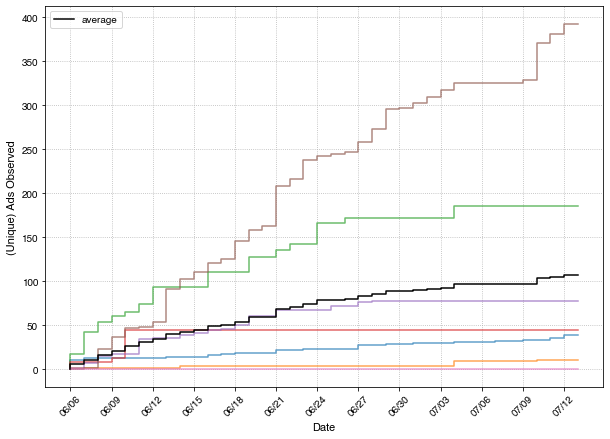

In [13]:
# at what rate is each user contributing *new* ads to the database
f, ax = plt.subplots(figsize=(10, 7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())

user_day_ads = {}

for uid in user_ads:
    contribs = aggregate_observations(user_ads[uid])
    user_day_ads[uid] = contribs
    
timelines, date_range = build_timeline(user_day_ads)
aggregate = []
for uid in timelines:        
    ax.step(date_range, timelines[uid], alpha=.7)
    aggregate.append(timelines[uid])
    
# plot average
ax.step(date_range, np.mean(np.array(aggregate), axis=0), color='k', label='average')
    
ax.grid(ls=':')
ax.legend()
ax.set_ylabel('(Unique) Ads Observed', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
plt.xticks(date_range[::3], rotation=45)
# ax.set_title('Unique ads observed over time')

plt.savefig('ads_data_rate.jpg', dpi=200, bbox_inches='tight')

### Data Contribution: volume and rate

In [17]:
aggregate = np.array(aggregate)

# average and median number of ads we can expect each day, after 2 weeks of data collection
print('mean ads contributed at the end of ~2 weeks: ',
      round(np.mean(np.array(aggregate[:,-1])), 2))

# median of medians: per day median across participants -> median again
print('median ads contributed at the end of ~2 weeks: ',
      round(np.median(np.median(aggregate[:,-1], axis=0)), 2))

mean ads contributed at the end of ~2 weeks:  83.71
median ads contributed at the end of ~2 weeks:  45.0


In [18]:
aggregate = np.array(aggregate)

rate = np.diff(aggregate, axis=1)
print('mean rate of contributing ads, per user, per day:')
print(np.mean(rate, axis=1))

print('overall mean:')
print(np.mean(rate))

print('\nmedian rate of contributing ads, per user, per day:')
print(np.median(rate, axis=1))

print('overall median:')
print(np.median(rate))

mean rate of contributing ads, per user, per day:
[ 1.2173913   0.17391304  7.47826087  1.95652174  3.34782609 11.26086957
  0.04347826]
overall mean:
3.639751552795031

median rate of contributing ads, per user, per day:
[0. 0. 6. 0. 2. 8. 0.]
overall median:
0.0


### What's the overlap like between users?

Computing from `adid_pid.tsv` (exported by `fetch-messages.py`) in the ad-categories analysis, there is currently 0 overlap between the users in seeing these ads.